# KNN Classifier using features that matter

**Goal**: Build a KNN classifier that uses only the features that matter, and gives more weight to the most useful ones.
**Dataset**: sklearn.datasets.load_breast_cancer (binary classification; 30 numeric features).

## Plan (broad → focused):
1. **Baseline with all features** (Pipeline: StandardScaler → KNeighborsClassifier).
Purpose: establish a reference accuracy.
2. **Filter method**: rank features by Mutual Information (MI) with the target, then test top-k subsets via cross-validation.
Purpose: fast, model-agnostic signal of relevance.
3. **Wrapper method**: Sequential Forward Selection (SFS) wrapped around the KNN pipeline.
Purpose: pick a subset that optimizes CV accuracy for the actual model.
4. **Model-agnostic importance**: Permutation importance on a validation set using the chosen subset.
Purpose: sanity-check and quantify which selected features the model truly uses.
5. **Weighted KNN**: convert permutation importances into per-feature weights and use weighted Minkowski distance (metric="wminkowski") so important features count more.
Purpose: bake “feature importance” directly into the distance metric.
6. **Finalization**: pick (unweighted vs weighted) by validation accuracy, refit on train+val, and evaluate on the test set.
Why this order? We start broad to understand signals cheaply (filter), then let the model choose (wrapper), then verify (permutation), then use that knowledge (weights), and finally lock it in (test).

Shapes -> train: (341, 30) val: (114, 30) test: (114, 30)

Baseline (all features) CV accuracy: mean=0.9648, scores=[0.971  0.9118 1.     0.9706 0.9706]

Top 10 features by Mutual Information:
worst perimeter         0.473153
worst radius            0.465186
mean concave points     0.460651
worst area              0.452752
worst concave points    0.451801
mean perimeter          0.409273
mean concavity          0.352609
mean radius             0.337765
mean area               0.336319
area error              0.328567
dtype: float64


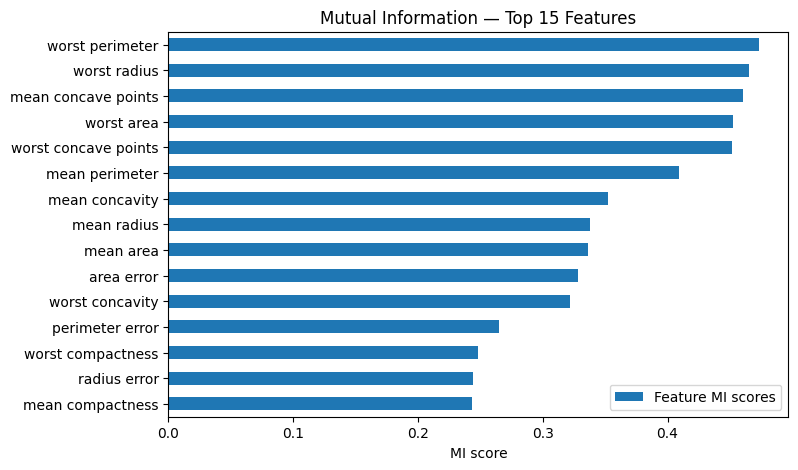


MI selection → best k=11 (CV acc=0.9561)


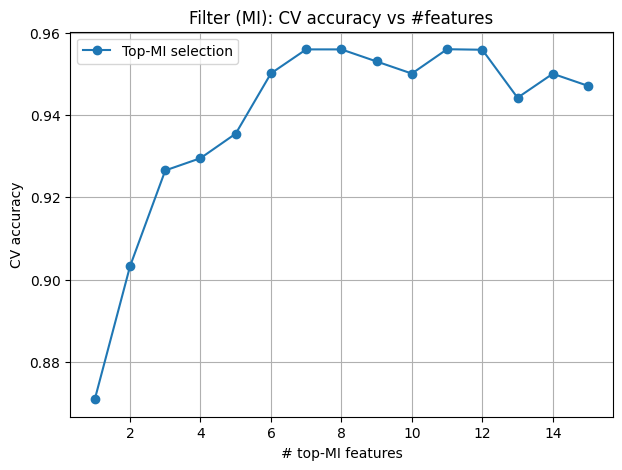


SFS selection → best k=8 (CV acc=0.9824)
Top features (first 8 shown): ['mean area', 'radius error', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst smoothness', 'worst concave points'] ...


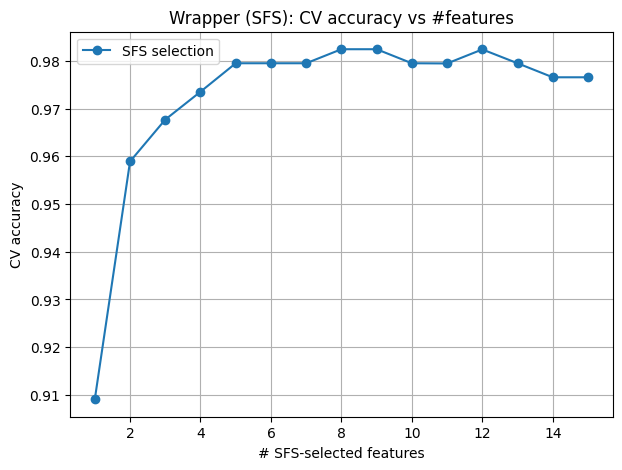


Validation accuracy (SFS subset, unweighted distance): 0.9649

Permutation importance (top 10):
worst concave points    0.05702
worst radius            0.03830
worst perimeter         0.03830
mean area               0.03246
worst texture           0.02982
worst smoothness        0.02018
radius error            0.01111
area error              0.01082
dtype: float64
[saved] /Volumes/cmnoyk SSD/CODE/_GIT-Repos/DATA-TEMPLATE/ml_examples/knn_feature_selection_figs/permutation_importance.png


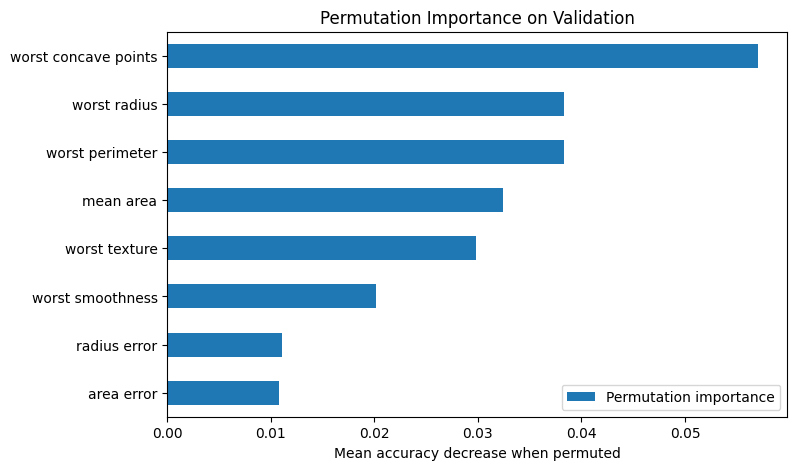

Validation accuracy (SFS subset, weighted distance via scaling): 0.9649

FINAL MODEL: Weighted KNN (scaled) using 8 features
Test accuracy: 0.9298

Confusion matrix (test):
[[39  3]
 [ 5 67]]

Classification report (test):
              precision    recall  f1-score   support

   malignant       0.89      0.93      0.91        42
      benign       0.96      0.93      0.94        72

    accuracy                           0.93       114
   macro avg       0.92      0.93      0.93       114
weighted avg       0.93      0.93      0.93       114



In [ ]:
# KNN classification with feature understanding, selection, and weighting
# --------------------------------------------------------------
# Requires: scikit-learn, numpy, pandas, matplotlib
# --------------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import mutual_info_classif, SequentialFeatureSelector
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42

# --- Utilities -------------------------------------------------

def save_or_show(fig, filename=None):
    """
    Saves the figure to /mnt/data/knn_feature_selection_figs (if filename given)
    and tries to show it as well. If show() fails (e.g., headless), the file is still saved.
    """
    if filename is not None:
        out_dir = os.path.join(os.getcwd(), "knn_feature_selection_figs")
        os.makedirs(out_dir, exist_ok=True)
        path = os.path.join(out_dir, filename)
        fig.savefig(path, bbox_inches="tight")
        print(f"[saved] {path}")
    try:
        plt.show()
    except Exception:
        pass
    plt.close(fig)

def cv_score_with_features(X, y, feature_list, n_neighbors=5, cv=None):
    """Cross-validated accuracy using a standard KNN pipeline on a given feature subset."""
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=n_neighbors))
    ])
    scores = cross_val_score(pipe, X[feature_list], y, cv=cv, scoring="accuracy")
    return scores.mean(), scores

# --- 1) Load & split ------------------------------------------

data = load_breast_cancer()
X_full = pd.DataFrame(data.data, columns=data.feature_names)
y_full = pd.Series(data.target, name="target")

# 60% train, 20% val, 20% test (stratified)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=RANDOM_STATE
)
print("Shapes -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# --- 2) Baseline with all features -----------------------------

baseline_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5))
])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
baseline_cv = cross_val_score(baseline_pipe, X_train, y_train, cv=cv, scoring="accuracy")
print(f"\nBaseline (all features) CV accuracy: mean={baseline_cv.mean():.4f}, scores={np.round(baseline_cv, 4)}")

# --- 3) FILTER: Mutual Information ranking --------------------

# MI is neighbor-based; MinMax scaling helps it compare distances fairly
mm = MinMaxScaler()
X_train_mm = mm.fit_transform(X_train)
mi = mutual_info_classif(X_train_mm, y_train, random_state=RANDOM_STATE)
mi_series = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)
print("\nTop 10 features by Mutual Information:")
print(mi_series.head(10))

# Plot top-15 MI features
fig = plt.figure(figsize=(8, 5))
mi_series.iloc[:15][::-1].plot(kind="barh")
plt.title("Mutual Information — Top 15 Features")
plt.xlabel("MI score")
plt.legend(["Feature MI scores"])
save_or_show(fig)

# Evaluate top-k by MI (1..15)
k_grid = list(range(1, 16))
mi_cv_means = []
for k in k_grid:
    feats = list(mi_series.index[:k])
    mean_acc, _ = cv_score_with_features(X_train, y_train, feats, n_neighbors=5, cv=cv)
    mi_cv_means.append(mean_acc)

best_k_mi = k_grid[int(np.argmax(mi_cv_means))]
best_mi_feats = list(mi_series.index[:best_k_mi])
print(f"\nMI selection → best k={best_k_mi} (CV acc={max(mi_cv_means):.4f})")
fig = plt.figure(figsize=(7, 5))
plt.plot(k_grid, mi_cv_means, marker="o")
plt.title("Filter (MI): CV accuracy vs #features")
plt.xlabel("# top-MI features")
plt.ylabel("CV accuracy")
plt.legend(["Top-MI selection"])
plt.grid(True)
save_or_show(fig)

# --- 4) WRAPPER: Sequential Forward Selection (SFS) -----------

# Use a pipeline inside SFS so scaling happens correctly for each subset
sfs_base = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5))
])

sfs_cv_means = []
sfs_feature_sets = []
for k in k_grid:
    sfs = SequentialFeatureSelector(
        sfs_base,
        n_features_to_select=k,
        direction="forward",
        scoring="accuracy",
        cv=cv,
        n_jobs=-1
    )
    sfs.fit(X_train, y_train)
    mask = sfs.get_support()
    feats_k = list(X_train.columns[mask])
    sfs_feature_sets.append(feats_k)
    mean_acc, _ = cv_score_with_features(X_train, y_train, feats_k, n_neighbors=5, cv=cv)
    sfs_cv_means.append(mean_acc)

best_k_sfs = k_grid[int(np.argmax(sfs_cv_means))]
best_sfs_feats = sfs_feature_sets[int(np.argmax(sfs_cv_means))]
print(f"\nSFS selection → best k={best_k_sfs} (CV acc={max(sfs_cv_means):.4f})")
print("Top features (first 8 shown):", best_sfs_feats[:8], "...")

fig = plt.figure(figsize=(7, 5))
plt.plot(k_grid, sfs_cv_means, marker="o")
plt.title("Wrapper (SFS): CV accuracy vs #features")
plt.xlabel("# SFS-selected features")
plt.ylabel("CV accuracy")
plt.legend(["SFS selection"])
plt.grid(True)
save_or_show(fig)

# We'll proceed with the SFS-selected subset (usually strongest for KNN)
chosen_feats = best_sfs_feats

# --- 5) Permutation importance on validation set --------------

sfs_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5))
])
sfs_pipe.fit(X_train[chosen_feats], y_train)
val_pred = sfs_pipe.predict(X_val[chosen_feats])
val_acc = accuracy_score(y_val, val_pred)
print(f"\nValidation accuracy (SFS subset, unweighted distance): {val_acc:.4f}")

perm = permutation_importance(
    sfs_pipe, X_val[chosen_feats], y_val,
    n_repeats=30, random_state=RANDOM_STATE, scoring="accuracy"
)
perm_series = pd.Series(perm.importances_mean, index=chosen_feats).sort_values(ascending=False)

print("\nPermutation importance (top 10):")
print(np.round(perm_series.head(10), 5))

fig = plt.figure(figsize=(8, 5))
perm_series.iloc[:min(15, len(chosen_feats))][::-1].plot(kind="barh")
plt.title("Permutation Importance on Validation")
plt.xlabel("Mean accuracy decrease when permuted")
plt.legend(["Permutation importance"])
save_or_show(fig)

# --- 6) Weighted KNN via feature scaling instead of 'wminkowski' ---

from sklearn.base import BaseEstimator, TransformerMixin

class FeatureWeightScaler(BaseEstimator, TransformerMixin):
    """
    Multiplies each feature by w**(1/p), which makes standard Minkowski(p)
    equivalent to Weighted-Minkowski with weights w.
    """
    def __init__(self, w, p=2):
        self.w = np.asarray(w, dtype=float)
        self.p = p

    def fit(self, X, y=None):
        X = np.asarray(X)
        if X.shape[1] != self.w.shape[0]:
            raise ValueError(f"Weight length {self.w.shape[0]} != n_features {X.shape[1]}")
        # zero weights are allowed (feature gets ignored)
        self.scale_ = np.power(np.clip(self.w, a_min=0.0, a_max=None), 1.0 / self.p)
        return self

    def transform(self, X):
        return np.asarray(X) * self.scale_

# (same as before) turn permutation importance into weights, normalize to mean=1
imp = perm_series.reindex(chosen_feats).fillna(0.0).clip(lower=0.0)
if (imp == 0).all():
    w = np.ones(len(chosen_feats))
else:
    w = imp.values
    w = w / (w.mean() if w.mean() != 0 else 1.0)

p = 2  # Minkowski p (2 = Euclidean)
weighted_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("wscale", FeatureWeightScaler(w=w, p=p)),
    ("knn", KNeighborsClassifier(n_neighbors=5, metric="minkowski", p=p))
])

weighted_pipe.fit(X_train[chosen_feats], y_train)
val_pred_w = weighted_pipe.predict(X_val[chosen_feats])
val_acc_w = accuracy_score(y_val, val_pred_w)
print(f"Validation accuracy (SFS subset, weighted distance via scaling): {val_acc_w:.4f}")

# --- 7) Final model & test evaluation (unchanged logic) -------

use_weighted = val_acc_w >= val_acc
final_pipe = weighted_pipe if use_weighted else sfs_pipe
final_label = "Weighted KNN (scaled)" if use_weighted else "Unweighted KNN"

X_train_final = pd.concat([X_train, X_val], axis=0)
y_train_final = pd.concat([y_train, y_val], axis=0)
final_pipe.fit(X_train_final[chosen_feats], y_train_final)

test_pred = final_pipe.predict(X_test[chosen_feats])
test_acc = accuracy_score(y_test, test_pred)
print(f"\nFINAL MODEL: {final_label} using {len(chosen_feats)} features")
print(f"Test accuracy: {test_acc:.4f}")
print("\nConfusion matrix (test):")
print(confusion_matrix(y_test, test_pred))
print("\nClassification report (test):")
print(classification_report(y_test, test_pred, target_names=data.target_names))